In [1]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d

# from jupyter_server import serverapp as app; 
# import ipykernel, requests;

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

In [3]:
import analysis.mathematical_functions.funcs as funcs

In [4]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [5]:
output_folder= project_path+'/outputs/'

In [6]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [7]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [8]:
%load_ext autoreload

In [9]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [10]:
data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]

'pas//01-10-19--04-06-2023'

In [11]:
if len(data_files)==1:
    dataname = data_files[0][data_files[0].find('//')+2:]
    results_name = results_folder+'/'+dataname
else:
    raise ValueError

In [12]:
#turn off warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
internal_results = os.getcwd()+'/results/'
os.makedirs(internal_results ,exist_ok=True)

In [14]:
def calc_t_peak(R0,kappa,N):
    ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),5000)
    x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
    tp = ts_det[np.argmax(y)]
    return tp

if os.path.exists(internal_results+'/filtered_df.feather'):
    filtered_df = pd.read_feather(internal_results+'/filtered_df.feather')
else:
    filtered_df = datadf[~datadf.isin([np.inf, -np.inf]).any(axis=1)]
    p_alpha = datadf['p_alpha'].unique()[0]

    filtered_df['muN'] =np.round(filtered_df['mutation_rate']*filtered_df['N'])

    filtered_df['first_d_over_xi']=filtered_df['first_d']/filtered_df['xi']
    filtered_df['$R_0$'] = filtered_df['infection_rate']
    filtered_df['$\mu N$'] = np.round(filtered_df['muN'],0)

    exp_number_mutants = lambda R0, kappa, xi, p_alpha: (1-funcs.x_inf(R0,kappa))**2/(2 + 2*(p_alpha*xi))
    filtered_df['exp_number_mutants'] = filtered_df.apply(lambda row: exp_number_mutants(row['infection_rate'],row['kappa'],row['xi'],p_alpha), axis=1)
    filtered_df['t_first_times_mu'] = filtered_df['first_tb']*filtered_df['mutation_rate']

    filtered_df['scaled_first_d'] = filtered_df['first_d']*filtered_df['p_alpha']
    
    filtered_df['scaled_kappa'] = filtered_df['kappa']/ ( (filtered_df['muN']/(2*filtered_df['infection_rate']) ))#- (filtered_df['infection_rate']-1)/filtered_df['infection_rate'])

    filtered_df['t_peak'] = filtered_df.apply(lambda row: calc_t_peak(row['infection_rate'], row['kappa'], N), axis=1)
    filtered_df['scaled_first_tb'] = filtered_df['first_tb']/filtered_df['t_peak']

    filtered_df['scaled_first_d'] = filtered_df['first_d']*filtered_df['p_alpha']
    # filtered_df['scaled_first_tb'] = filtered_df['first_tb']/filtered_df['kappa']*filtered_df['infection_rate']

    #save filtered df
    filtered_df.reset_index().to_feather(internal_results+'/filtered_df.feather')

In [15]:
def get_p_evo_from_df(R0,mu,xi, datadf):
    dpdf = datadf.query(f'infection_rate =={R0} & mutation_rate=={mu} & xi=={xi}')
    return 1-len(dpdf[datadf.isin([np.inf, -np.inf]).any(axis=1)])/len(dpdf)

if not os.path.exists(results_name+'p_evo_df.feather'):
    p_evo_df = pd.DataFrame.from_dict({i:(mu,xi,r ,get_p_evo_from_df(r,mu,xi,datadf)) for i,(mu,xi,r) in enumerate(funcs.product(mu_s,xi_s,R0s))},orient='index', columns=['mu','xi','R0','p_evo'])
    p_evo_df.to_feather(results_name+'p_evo_df.feather')
else:
    p_evo_df = pd.read_feather(results_name+'p_evo_df.feather')
    

p_evo_df['N']=N
p_evo_df['muN'] =np.round(p_evo_df['mu']*p_evo_df['N'],0)

In [16]:
#ignore warnings 
import warnings
warnings.filterwarnings("ignore")
p_alpha = datadf['p_alpha'].unique()[0]
xi_d = -1/np.log(1-p_alpha)

color_mus = funcs.color_dict(mu_s, plt.cm.jet)
colors_kappa = funcs.color_dict(kappa_s[kappa_s>=100], plt.cm.inferno)


In [17]:
def get_z_intersection(zfunc, d,tb, R0, N, xi, kappa):
    #to solve: -Log(-1 + (N*(-1 + R0*(1 - z)))/\[Kappa]) - (\[Kappa]*(1 - c(d))*((-1 + R0)*Log((-1 + R0*(1 - zx(d,z)))/(-1 + R0*(1 - z))) + R0*Log((1 - z)/(1 - zx(d,z)))))/R0
    s_d_z= lambda z,d : (1-np.exp(-d/xi))*z/(1-z)
    to_solve = lambda zx, z,d : - np.log(-1 + (N*s_d_z(z,d)  *(-1 + R0*(1 - z)))/kappa) - (kappa*(1 - np.exp(-d/xi))*((-1 + R0)*np.log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z))) + R0*np.log((1 - z)/(1 - zx))))/R0

    zstart =zfunc(tb)
    zx= spo.fsolve(to_solve, .5, args=(zstart, d))
    return zx[0]


def add_z_columns_frequency_intersection(df, R0s, kappa_s, mu_s, xi_s, N):
    qdfs_list = []
    
    for x in funcs.product(R0s,kappa_s,mu_s,xi_s):
        R0,kappa,mu,xi = x
        qstring = f'xi=={xi} and infection_rate=={R0} and kappa=={kappa} and mutation_rate=={mu}'    
        ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),1000)
        dt = ts_det[1]-ts_det[0]
        x,y,z= odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
        z_func = interp1d(ts_det,z)


        #update the dataframe at infection rate R0 and kappa 
        qdf = df.query(qstring)
        qdf['z_intersection_predicted'] = qdf.apply(lambda row: get_z_intersection(z_func, row['first_d'], row['first_tb'], R0, N, xi, kappa), axis=1)
        qdf['z_intersection'] = qdf.apply(lambda row: z_func(row['t_x']), axis=1)
        qdf['z_b'] = qdf.apply(lambda row: z_func(row['first_tb']), axis=1)
        qdfs_list.append(qdf)


    print(len(qdfs_list))
    return qdfs_list 

In [18]:
if os.path.exists(internal_results+'/z_df.feather'):
    z_df = pd.read_feather(internal_results+'/z_df.feather')
else:
    qdfs_list = add_z_columns_frequency_intersection(filtered_df, R0s, kappa_s, mu_s, xi_s, N)
    z_df = pd.concat(qdfs_list, ignore_index=True)
    #conver column z_intersection to float
    z_df['z_intersection'] = z_df['z_intersection'].astype(float)
    z_df['z_b'] = z_df['z_b'].astype(float)
    z_df.to_feather(internal_results+'/z_df.feather')


In [19]:
def get_z_intersection(zfunc, d,tb, R0, N, xi, kappa):
    #to solve: - Log(N*(1-c(d)))
    s_d_z= lambda z,d : (1-np.exp(-d/xi))*z/(1-z)
    to_solve = lambda zx, z,d : - np.log(-1 + N*s_d_z(z,d)*((-1 + R0*(1 - z)))/kappa) - (kappa*(1 - np.exp(-d/xi))*((-1 + R0)*np.log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z))) + R0*np.log((1 - z)/(1 - zx))))/R0

    zstart =zfunc(tb)
    zx= spo.fsolve(to_solve, .5, args=(zstart, d))
    return zx[0]

In [20]:
import math

In [21]:
#zx eq : \[Kappa]*(Log(1 - zX) - Log(1 - 2/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))) +((-1 + R0)*(-Log(-1 + R0 - R0*zX) + Log(-1 + R0 - (2*R0)/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))))))/R0) +((Log(N0) - Log(\[Kappa]) + Log(2 - 2*c(d)) - Log(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))) - Log(1 - 2/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))) +Log(-1 + R0 - (2*R0)/(1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d)))))*(-1 + Sqrt(1 - 4*\[Mu]N*(-1 + c(d))*\[Rho](d))))/(2.*(-1 + c(d)))
R_d = lambda d, p_alpha:(1-p_alpha)**(d)
rho_d = lambda d, p_alpha: p_alpha*(1-p_alpha)**(d)
# R_d = lambda d, p_alpha: p_alpha*(1-p_alpha)**(d)
c_d = lambda d, xi: np.exp(-d/xi)
zx_eqn = lambda zx, d, kappa, R0, mu, N, xi, p_alpha: kappa*(np.log(1-zx) - np.log(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + ((-1+R0)*(-np.log(-1+R0-R0*zx) + np.log(-1+R0-(2*R0)/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha))))))/R0) + ((np.log(N) - np.log(kappa) + np.log(2-2*c_d(d,xi)) - np.log(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + np.log(-1+R0-(2*R0)/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))*(-1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))/(2*(-1+c_d(d,xi)))

#zx_eq2 =         \[Kappa]*(Log((1 - zX)/(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d))))) + ((-1 + R0)*Log((-1 + R0*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))))/(-1 + R0*(1 - zX))))/R0) -(Log((N0*(-1 + R0*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d))))))/\[Kappa])*(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))*(1 - 2/(1 + Sqrt(1 + 4*\[Mu]N*(1 - c(d))*\[Rho](d)))))/(2.*(1 - c(d)))
zx_eqn2 = lambda zx, d, kappa, R0, mu, N, xi, p_alpha: kappa*(np.log((1-zx)/(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))) + ((-1+R0)*np.log((-1+R0*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))/(-1+R0*(1-zx))))/R0) - (np.log((N*(-1+R0*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha))))))/kappa)*(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))*(1-2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))))/(2*(1-c_d(d,xi))))

# zx_eq_W = 

#zb_func = 2/(1 + Sqrt[1 + 4 \[Mu]N (1 - c[d]) \[Rho][d]])
zb_func = lambda d, mu, N, xi: 2/(1+np.sqrt(1+4*mu*N*(1-c_d(d,xi))*R_d(d,p_alpha)))

def get_zx(zx_eqn, d, kappa, R0, mu, N, xi, p_alpha, ax= None):
    #find zero of zx_eqn
    zxs_to_test= np.linspace(0,1,1000)
    zx_eqn_vals = zx_eqn(zxs_to_test, d, kappa, R0, mu, N, xi, p_alpha)
    zx_eqn_vals[np.isnan(zx_eqn_vals)] = np.inf
    if ax is not None:
        ax.plot(zxs_to_test, zx_eqn_vals)
    zx = zxs_to_test[np.argmin(np.abs(zx_eqn_vals))]
    return zx

def get_zx2(zx_eqn2, d, kappa, R0, mu, N, xi, p_alpha, ax= None):
    #find zero of zx_eqn
    zxs_to_test= np.linspace(0,1,1000)
    zx_eqn_vals = zx_eqn2(zxs_to_test, d, kappa, R0, mu, N, xi, p_alpha)
    zx_eqn_vals[np.isnan(zx_eqn_vals)] = np.inf
    if ax is not None:
        ax.plot(zxs_to_test, zx_eqn_vals)
    zx = zxs_to_test[np.argmin(np.abs(zx_eqn_vals))]
    return zx


In [22]:
t_peaks = {}
for R0 in R0s:
    t_peaks_R0= []
    for kappa in kappa_s:
        ts_det = np.linspace(0,funcs.T_ext_deterministic(R0,kappa,N),5000)
        x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T
        tp = ts_det[np.argmax(y)]
        t_peaks_R0.append(tp)
    t_peaks[R0] = np.array(t_peaks_R0)


In [23]:
###### ###### ######  analytical solutions for yp and zp

def A(R0,kappa):
    return (R0 + (R0-1)*kappa)/(R0**2)

def ypGeneralFun(R0, kappa):
    rho = kappa/R0

    part1 = 1/(rho-1) * np.power(A(R0,kappa),-1/(rho-1))
    part2 = (1/kappa-1/(rho-1))*np.power(A(R0,kappa),-1/(1-1/rho)) 

    return part1 + part2 - 1/kappa


def zpGeneralFun(R0, kappa):
    rho = kappa/R0
    part1 = 1/(1-1/rho)* np.power(A(R0,kappa),-1/(rho-1))
    part2 = (1/kappa-1/(rho-1))*np.power(A(R0,kappa),-1/(1-1/rho))

    return 1+ 1/kappa -part1-part2

##################### soluion for zx in the luria delbruck regime

def zx_LD(d, R0, kappa, mu, N, p_alpha, xi ):
    yp_val = ypGeneralFun(R0, kappa)
    zp_val = zpGeneralFun(R0, kappa)
    c = np.exp(-d / xi)

    term1= np.exp(-(1-zp_val))*(1-zp_val)
    if mu*N*zp_val*np.exp(-(d-1)*p_alpha)>1:
        # print(mu*N*zp_val)
        term2 = np.maximum(1/(N*yp_val), zp_val/yp_val *mu* np.exp(-(d-1)*p_alpha))**(yp_val/(1-c))
    else:
        # print('returning inf')
        return np.inf
    
    result = 1 + np.real(sps.lambertw(-term1 * term2))
    return result

In [24]:
import time 


#zx_z_to_solve = \[Kappa]*(1 - c(d))*(-(((-1 + R0)*Log((-1 + R0*(1 - zx))/(-1 + R0*(1 - z0))))/R0) + Log((1 - zx)/(1 - z0))) - Log((N0*(-1 + R0*(1 - z))*z*(1 - c(d)))/((1 - z)*\[Kappa]))


## strain size at emergence, as a function of the recovered fraction
initial_size = lambda z,d, kappa, R0, N,xi:  (N*(-1+R0*(1-z))*z*(1-c_d(d,xi)))/((1-z)*kappa)

#initial frequency
chi_0 = lambda z,d, kappa, R0, N,xi:  1/initial_size(z,d, kappa, R0, N,xi)

#defining the equation to solve for intersection z (zx)
zx_z_to_solve= lambda zx, z, d, kappa, R0, N, xi,: kappa*(1-c_d(d,xi))*(-(((-1+R0)*np.log((-1+R0*(1-zx))/(-1+R0*(1-z))))/R0) + np.log((1-zx)/(1-z))) - np.log((1- chi_0(z,d, kappa, R0, N,xi))/chi_0(z,d, kappa, R0, N,xi))


##### three methods to solve for zx as a function of z
def get_zx_z(z, d, kappa, R0, N, xi, time_iteration = False):
    start_time = time.time()
    zx, infodict, ier, mesg  = spo.fsolve(zx_z_to_solve,.595 , args=(z, d, kappa, R0, N, xi),full_output=True)
    if ier != 1:
        # print(mesg)
        zx = np.inf
    if time_iteration: print(f'zx_z_to_solve took {time.time()-start_time} seconds')
    return zx

def get_zx_no_solver(z,d,kappa,R0,N,xi, ax= None, time_iteration = False):
    start_time= time.time()
    zxs_to_test= np.linspace(0,1-1/R0,1000)
    zx_z_to_solve_vals = np.array([zx_z_to_solve(zz, z, d, kappa, R0, N, xi) for zz in zxs_to_test])
    zx_z_to_solve_vals[np.isnan(zx_z_to_solve_vals)] = np.inf
    if ax is not None:
        ax.plot(zxs_to_test, zx_z_to_solve_vals)
    try:
        zx = zxs_to_test[np.where(np.diff(np.sign(zx_z_to_solve_vals)))[0][0]]
        # print(zx)
    except IndexError:
        zx = np.nan
    if time_iteration: print(f'get_zx_no_solver took {time.time()-start_time} seconds')
    return zx

def get_zx_z_method( z, d, kappa, R0, N, xi, method ='bisect'):
    z_p = R0/kappa*(np.log((R0-1)/R0**2 *kappa) - (R0-1)/R0)
    z_inf = 1-1/R0*(1-R0/kappa)
    zx = spo.root_scalar(zx_z_to_solve, args=(z, d, kappa, R0, N, xi), x0= .59,x1 = z_inf*.9, method=method, bracket=[z_p,z_inf], xtol=1e-10)
    # print(zx)
    if zx.root<.2:
        zx.root = np.inf
    return zx.root

z_est = lambda d, mu, N, xi, p_alpha: 1 + np.real(sps.lambertw(-np.exp(-1 - np.power(N*mu*R_d(d,p_alpha)*(1-c_d(d,xi)),-1)))) # formula obtained by pi_s\sim s
z_est2 = lambda d, mu, N, xi, p_alpha: (1 + np.real(sps.lambertw(-np.exp(-(-1 + c_d(d,xi) - c_d(d,xi)**2/(mu*N*R_d(d,p_alpha)))/(-1 + c_d(d,xi))))))/c_d(d,xi) #formula obtained by pi_s\sim s/(1+s)

tot_expected_established = lambda z, mu, N, xi, p_alpha: mu*N*(np.exp(2*p_alpha)*(-1 + np.exp(1/xi))*p_alpha*z**2)/(2*(-1 + np.exp(p_alpha))*(-1 + np.exp(p_alpha + 1/xi))) #formula obtained by pi_s\sim s/(1+s)

z_inf_strong_control = lambda R0,kappa: 1-1/R0*(1-R0/kappa)

z_est_conditioned = lambda d, mu, N, xi, p_alpha, R0, kappa: z_est(d, mu/(1-tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha)/(np.exp(tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha))-1)), N, xi, p_alpha)
z_est2_conditioned = lambda d, mu, N, xi, p_alpha, R0, kappa: z_est2(d, mu/(1-tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha)/(np.exp(tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha))-1)), N, xi, p_alpha)

#Used functions!
def get_d_opt_zest(ds,mu, N , xi, p_alpha, R0, kappa):
    zest_values = np.array([ z_est2_conditioned(d, mu, N, xi, p_alpha,R0,kappa) for d in ds])
    # zx_values = np.array([ get_zx_z(z_est(d, mu, N, xi, p_alpha),d, kappa, R0, N, xi) for d in ds])
    d_opt = ds[np.argmin(zest_values)]

    return d_opt


def get_d_opt(ds, mu, N , xi, p_alpha, R0, kappa):
    zx_values = np.array([ get_zx_z_method(z_est2_conditioned(d, mu, N, xi, p_alpha, R0,kappa),d, kappa, R0, N, xi) for d in ds])
    # zx_values = np.array([ get_zx_z(z_est2(d, mu, N, xi, p_alpha),d, kappa, R0, N, xi) for d in ds])
    d_opt = ds[np.argmin(zx_values)]

    return d_opt

#Not used
def get_d_opt_alternative(mu, N , xi, p_alpha,R0,kappa):
    mu_renorm = mu/(1-tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha)/(np.exp(tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha))-1))
    #tosolve = lambda d: c_d(d,xi) - 1/(1+np.sqrt(mu_renorm*N/(xi*p_alpha*kappa)*R_d(d,p_alpha)*(R0*(1-z_est2_conditioned(d, mu, N, xi, p_alpha))-1)))
    tosolve = lambda d: c_d(d,xi) - 1/(1+np.sqrt(mu_renorm*N/(xi*p_alpha*kappa)*R_d(d,p_alpha)*(R0*(1-z_est2_conditioned(d, mu, N, xi, p_alpha,R0,kappa))-1)))

    d_opt = spo.root_scalar(tosolve, bracket=[5,40], xtol=1e-10).root

    return d_opt

In [25]:
ds = np.arange(0,z_df['first_d'].max())

d_mins_R0_xi_mu_kappa = {}
zb_mins_R0_xi_mu_kappa = {}

for R0 in R0s:
    d_mins_xi_mu_kappa = {}
    zb_mins_xi_mu_kappa = {}

    d_mins_xi_mu_kappa_zest = {}
    zb_mins_xi_mu_kappa_zest = {}
    
    for xi in xi_s:
        print((R0,xi))
        d_mins_mu_kappa = {}
        zb_mins_mu_kappa = {}

        d_mins_mu_kappa_zest = {}
        zb_mins_mu_kappa_zest = {}

        d_mins_mu_kappa_test = {}
        for mu in mu_s:
            d_mins = []
            zb_mins = []

            d_mins_zest = []
            zb_mins_zest = []

            # d_mins_test = []

            print(mu, end=': ')
            for kappa in kappa_s[kappa_s>10]:
                d_opt = get_d_opt(ds, mu, N , xi, p_alpha, R0, kappa)
                print(d_opt, end=' ')
                d_mins.append(d_opt) # this works better with + 1/p_alpha
                zb_mins.append(z_est2_conditioned(d_opt, mu, N, xi, p_alpha, R0, kappa))

                d_opt_zest = get_d_opt_zest(ds, mu, N , xi, p_alpha, R0, kappa)

            print()
            d_mins = np.array(d_mins)
            zb_mins = np.array(zb_mins)

            d_mins_mu_kappa[mu] = d_mins
            zb_mins_mu_kappa[mu] = zb_mins

        d_mins_xi_mu_kappa[xi] = d_mins_mu_kappa
        zb_mins_xi_mu_kappa[xi] = zb_mins_mu_kappa
    
    d_mins_R0_xi_mu_kappa[R0] = d_mins_xi_mu_kappa
    zb_mins_R0_xi_mu_kappa[R0] = zb_mins_xi_mu_kappa

(2.5, 20.0)
1e-07: 5.0 4.0 4.0 4.0 4.0 4.0 
1e-06: 1.0 1.0 1.0 1.0 1.0 1.0 
1e-05: 1.0 1.0 1.0 1.0 1.0 1.0 
(2.5, 50.0)
1e-07: 0.0 6.0 5.0 5.0 5.0 5.0 
1e-06: 2.0 2.0 2.0 2.0 2.0 2.0 
1e-05: 1.0 1.0 1.0 1.0 1.0 1.0 
(4.5, 20.0)
1e-07: 3.0 2.0 2.0 2.0 2.0 2.0 
1e-06: 1.0 1.0 1.0 1.0 1.0 1.0 
1e-05: 1.0 1.0 1.0 1.0 1.0 1.0 
(4.5, 50.0)
1e-07: 3.0 3.0 3.0 3.0 3.0 3.0 
1e-06: 1.0 1.0 1.0 1.0 1.0 1.0 
1e-05: 1.0 1.0 1.0 1.0 1.0 1.0 


In [26]:
colors_kappa = funcs.color_dict(kappa_s, plt.cm.inferno)

In [27]:
zinf = lambda R0, kappa: 1/(1-1/R0*(1-R0/kappa))
yp = lambda R0, kappa: (R0-1)/kappa
zp= lambda R0, kappa: 0

test_d = lambda d, p_alpha, xi, muN:  1/np.sqrt(muN*yp(R0,kappa)*R_d(d,p_alpha)*(1-c_d(d,xi))*zinf(R0,kappa)*R0/(2*kappa))
lin_sel_d = lambda t, d, xi, R0,kappa: zp(R0,kappa) * (1 - c_d(d, xi)) \
    + (R0 * t * (zinf(R0,kappa) - zp(R0,kappa)) * (1 - c_d(d, xi)))/kappa
tfix_lin_s = lambda t, d,xi, R0,kappa,N: np.sqrt(t**2+2*kappa/R0 /((1-c_d(d,xi))*zinf(R0,kappa))*np.log(N*yp(R0,kappa)*np.exp(-t*R0/kappa)*lin_sel_d(t,d,xi, R0, kappa)))

def get_d_opt(ds, mu, N , xi, p_alpha, R0, kappa, renorm_mu = False):

    if renorm_mu:
        mu_renorm = mu/(1-tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha)/(np.exp(tot_expected_established(z_inf_strong_control(R0,kappa),  mu, N, xi, p_alpha))-1))
    else:
        mu_renorm = mu

    tfix_values = np.array([tfix_lin_s(test_d(d, p_alpha, xi, mu*N), d, xi, R0, kappa,N) for d in ds])

    available_inds = ~np.isinf(tfix_values) & ~np.isnan(tfix_values) 

    d_opt = ds[available_inds][np.argmin(tfix_values[available_inds])]
    return d_opt
    
d_opt_df = pd.DataFrame(columns = ['infection_rate', 'mutation_rate', 'xi', 'p_alpha', 'kappa', 'scaled_first_d', 'scaled_first_tb'])
for R0 in tqdm(R0s):
    for xi in xi_s:
        for mu in mu_s:
            for kappa in kappa_s:
                d_opt = get_d_opt(ds, mu, N , xi, p_alpha, R0, kappa, renorm_mu = True)
                tb = test_d(d_opt, p_alpha, xi, mu*N)
                t_peak = calc_t_peak(R0,kappa,N)
                d_opt_df = pd.concat([d_opt_df, pd.DataFrame({'infection_rate': [R0], 'mutation_rate': [mu], 'xi': [xi], 'p_alpha': [p_alpha], 'kappa': [kappa], 'scaled_first_d': [1+ d_opt*p_alpha], 'scaled_first_tb': [tb/t_peak]})])
                # d_opt_df.append({'infection_rate': R0, 'mutation_rate': mu, 'xi': xi, 'p_alpha': p_alpha, 'kappa': kappa, 'scaled_first_d': 1+ d_opt*p_alpha, 'scaled_first_tb': tb/t_peak}, ignore_index=True)
    

100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


In [28]:

d_opt_df['muN']= d_opt_df['mutation_rate']*N
d_opt_df['scaled_kappa'] = d_opt_df['kappa']/ ( (d_opt_df['muN']/(2*d_opt_df['infection_rate']) ))#- (d_opt_df['infection_rate']-1)/d_opt_df['infection_rate'])

In [29]:
filtered_df['kappa_c'] =  (filtered_df['muN']/(2*filtered_df['infection_rate']))

100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


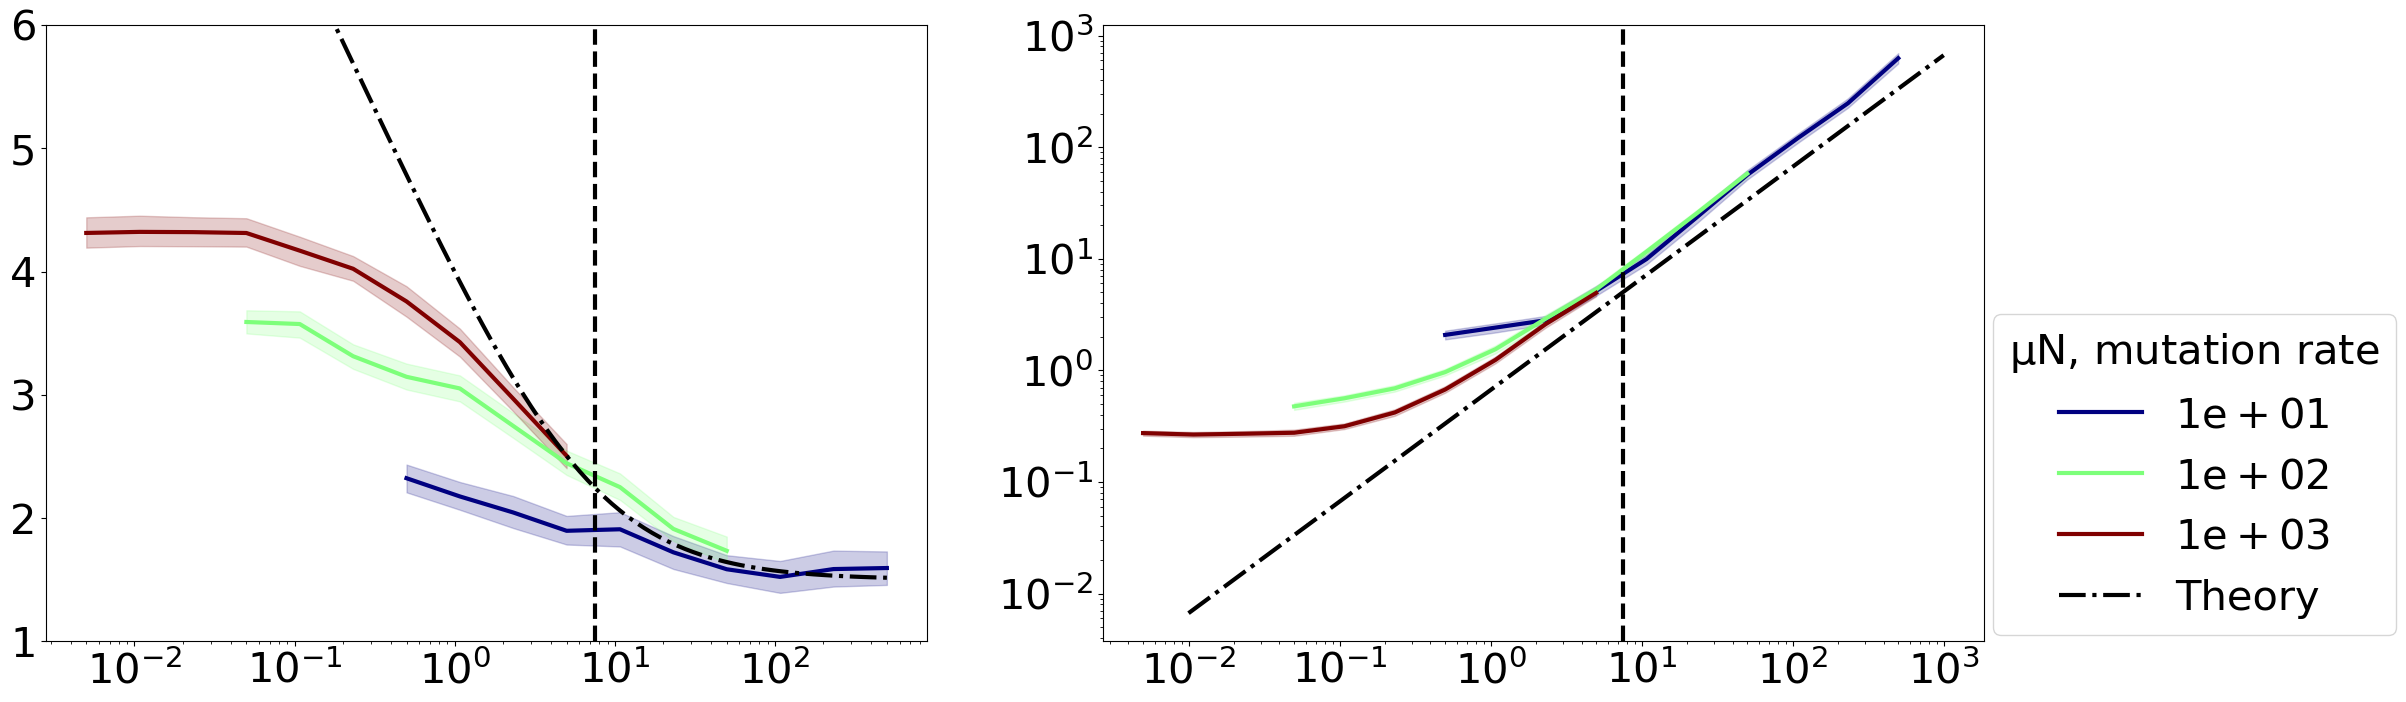

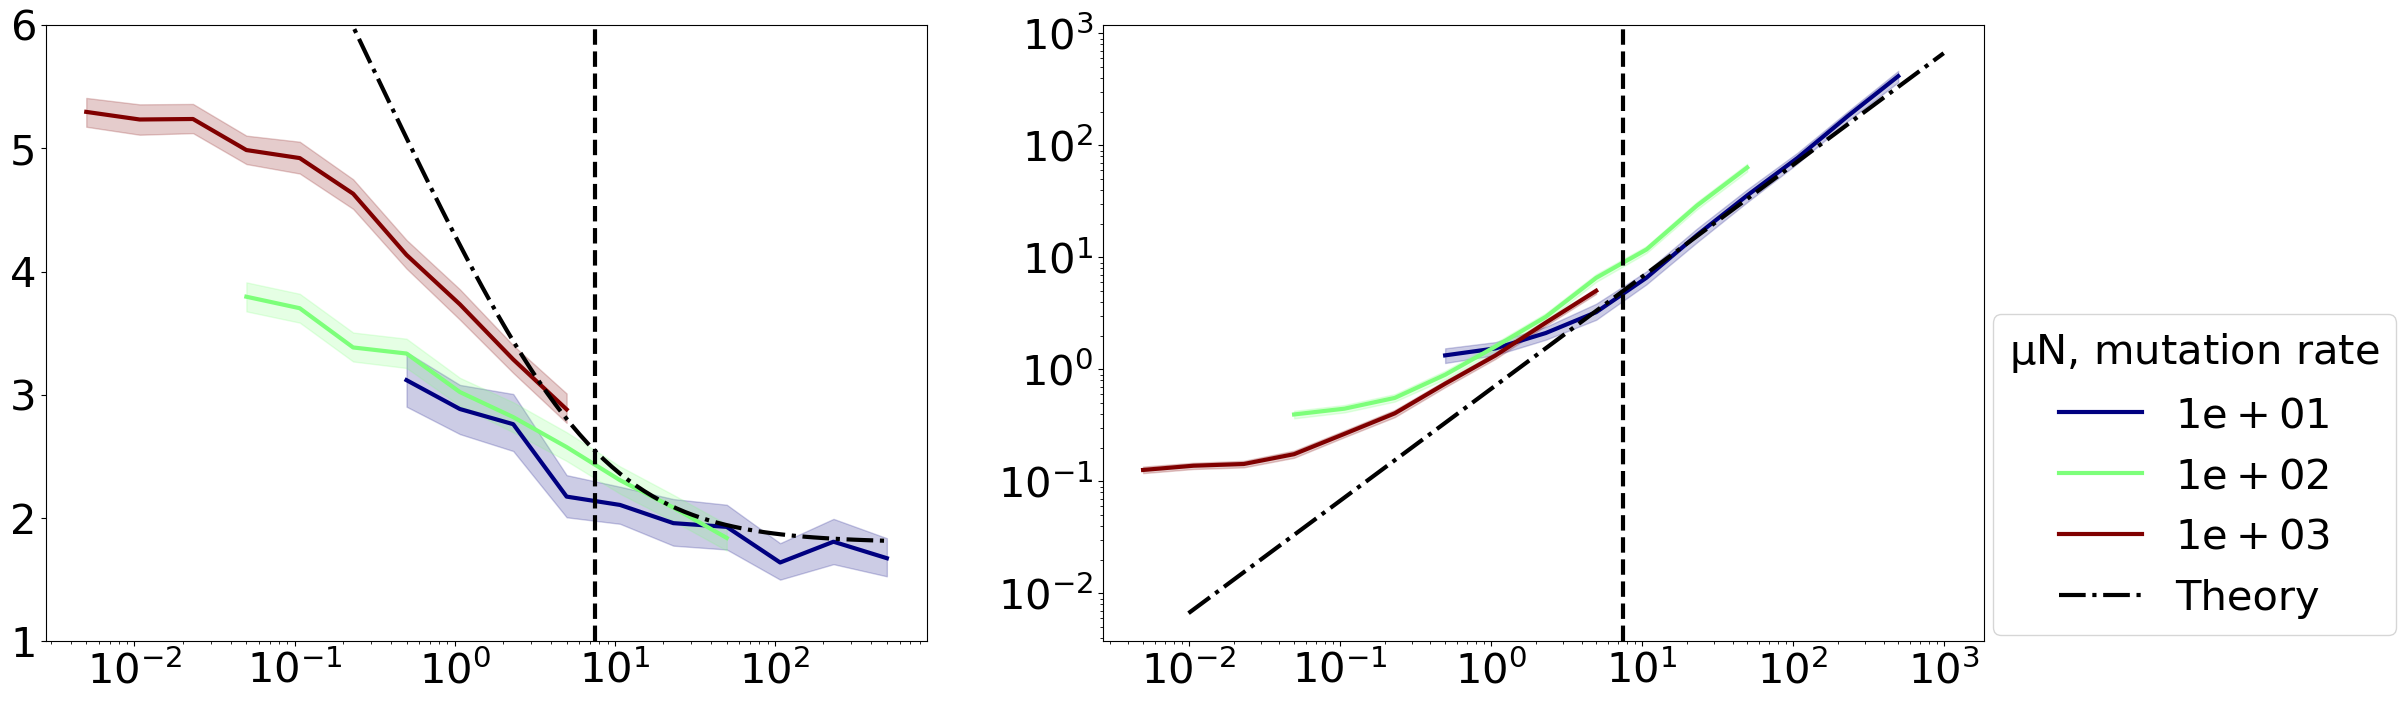

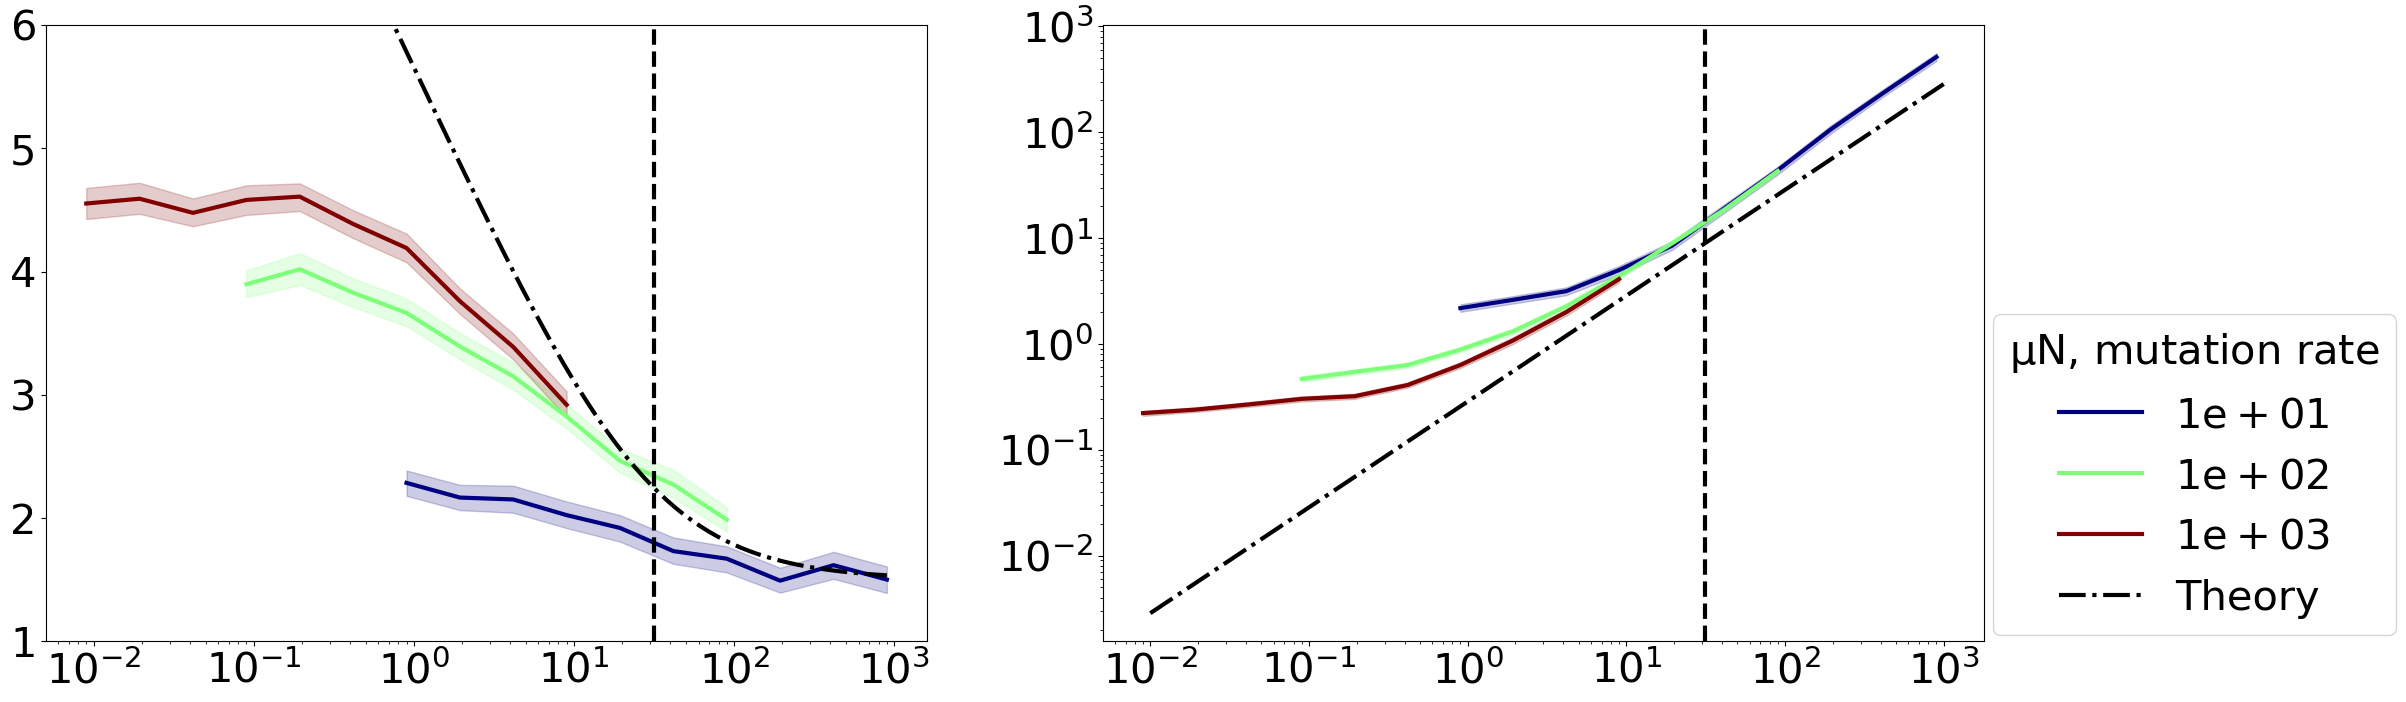

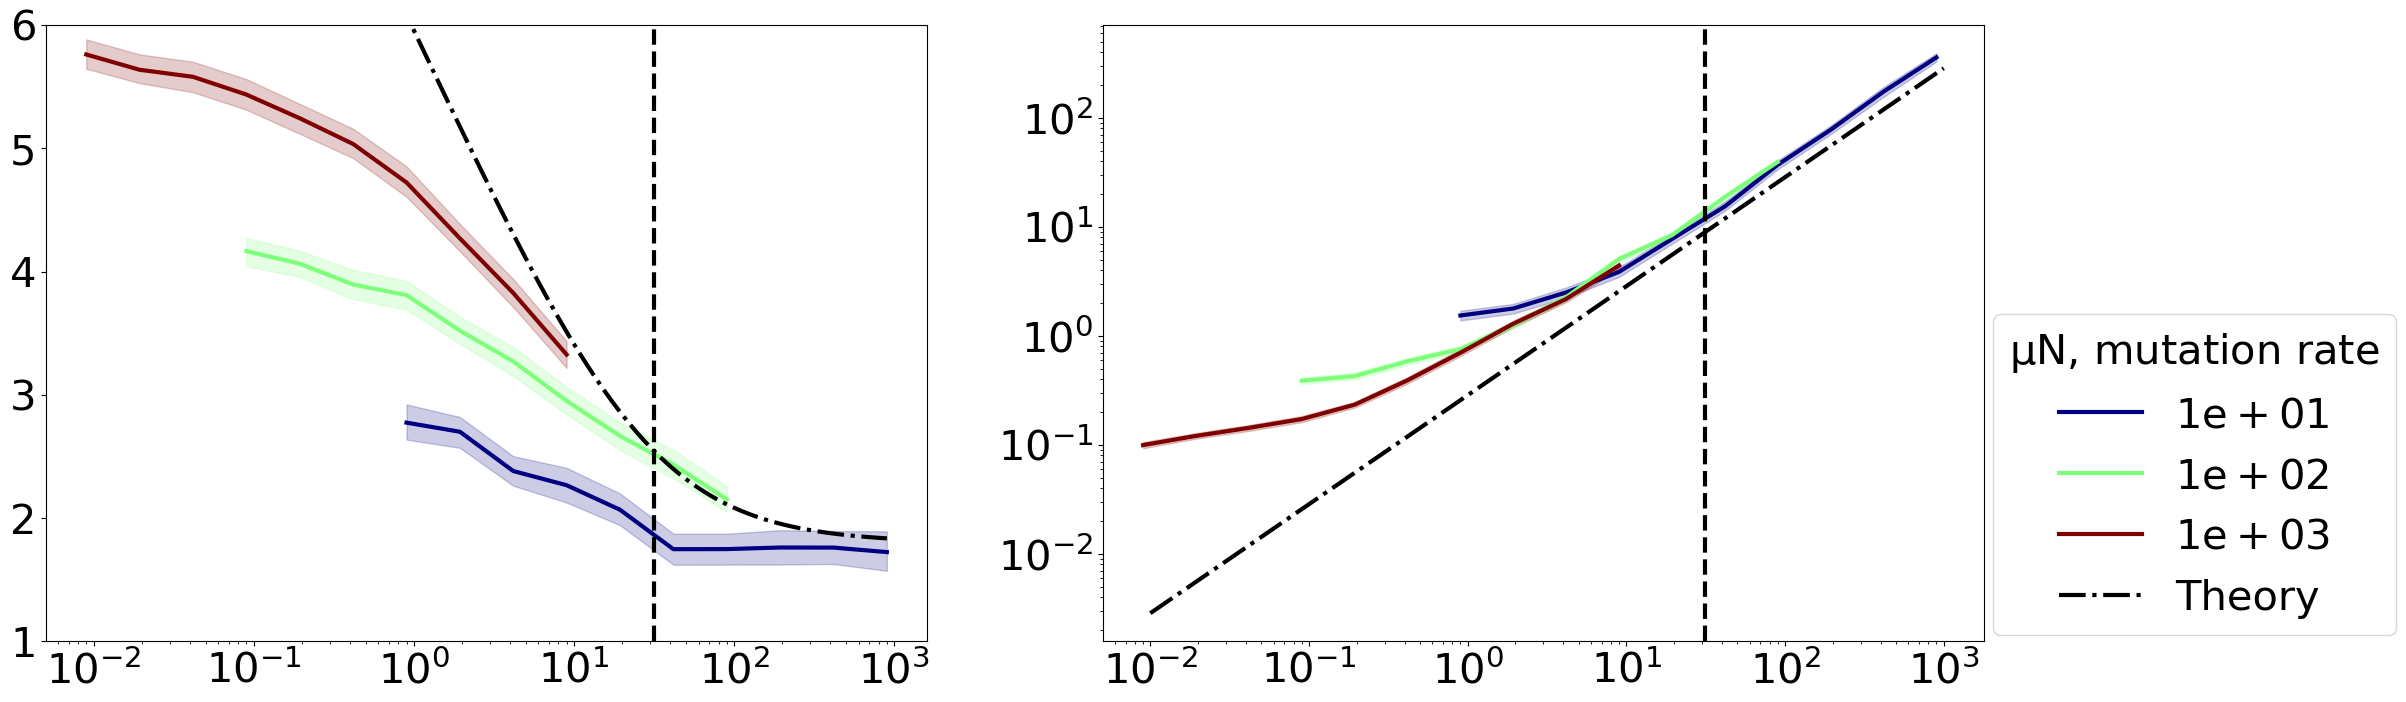

In [31]:
filtered_df['second_scaled_first_tb'] = np.abs(filtered_df['first_tb']-filtered_df['t_peak'])*np.sqrt(filtered_df['muN']/(filtered_df['p_alpha']*filtered_df['xi']))/filtered_df['kappa_c']
shifted =1
colors_mu = funcs.color_dict(mu_s,plt.cm.jet)
kappa_s_long = np.logspace(-2,3,100)
kappa_s_long_2 = np.logspace(0,5,100)
R0 = 2.5
dbar = 1/p_alpha
for R0 in R0s:
    # mu = mu_s[-1]
    for xi in xi_s:
        delta = dbar/xi
        
        fig,ax= plt.subplots(1,2, figsize=(25,8))
        plt.subplots_adjust(wspace=.2)
        ax = ax.T
                
        for mu in tqdm(mu_s):
            kc = mu*N/(2*R0)# - (R0-1)/R0,1)
            # cl, = ax[0].plot(kappa_s[kappa_s>10]/kc, (d_mins_R0_xi_mu_kappa[R0][xi][mu])*p_alpha + shifted ,linestyle=':',color=colors_mu[mu],lw=4)
            zb_mins = zb_mins_R0_xi_mu_kappa[R0][xi][mu]
            z_infs_strong_control = z_inf_strong_control(R0,kappa_s)
            z_infs_strong_control = z_infs_strong_control[kappa_s>10]
            tb_mins = kappa_s[kappa_s>10]/R0*np.log(z_infs_strong_control/(z_infs_strong_control-zb_mins)) /(1)
            short_kappas = kappa_s[kappa_s>10]
            t_peaks_short = t_peaks[R0][kappa_s>10]
            
            # ax[1].plot(short_kappas[tb_mins>0] / kc, (tb_mins/t_peaks_short)[tb_mins>0],linestyle=':',color=colors_mu[mu],lw=4)
            # cl, = ax[0].plot(short_kappas[tb_mins>0] / kc, (d_mins_R0_xi_mu_kappa[R0][xi][mu])[tb_mins>0] *p_alpha  + shifted ,linestyle=':',color=colors_mu[mu],lw=4)
            # ax[1].plot(kappa_s[kappa_s>R0], d_mins2,linestyle='--',color=colors_mu[mu])
            sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='scaled_kappa', y='scaled_first_d', ax=ax[0], color=color_mus[mu], estimator = np.mean)
            sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='scaled_kappa', y='second_scaled_first_tb', ax=ax[1], color=color_mus[mu], estimator = np.mean, label = f'${mu*N:.0e}$')

            scaled_kappa_vals = filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}').groupby('kappa')['scaled_kappa'].mean()
            kappa_vals = filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}').groupby('kappa')['kappa'].mean()
            first_tb_vals = filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}').groupby('kappa')['first_tb'].mean()
            # ax[1].plot(kappa_vals/kc, np.sqrt(mu*N*delta)/kc *(first_tb_vals - t_peaks[R0]), color=colors_mu[mu], linestyle='-')

            # sns.lineplot(data = d_opt_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='scaled_kappa', y='scaled_first_d', ax=ax[0],color=cl.get_color(),linestyle='-.')
            # sns.lineplot(data = d_opt_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='scaled_kappa', y='scaled_first_tb', ax=ax[1],color=cl.get_color(),linestyle='-.')
            

            #-0.5*(dbar*delta*np.log((mu*kappa_s)/(-1 + R0))**2*ProductLog(-2/E**2))/(1 + ProductLog(-2/E**2))**3 + (dbar*np.log((mu*kappa_s)/(-1 + R0)))/(1 + ProductLog(-2/E**2)) + (-2*dbar - dbar*ProductLog(-2/E**2))/delta
            t_exp = 1/(R0-1)*(np.log(R0/mu) + 1/delta* np.log(R0/(R0-1)))
            # ax[1].axhline(t_exp/t_peaks[R0][0], color=colors_mu[mu], linestyle='-.')
        m = 1 + .5*mu*N* (R0-1)/kappa_s_long_2
            # m_new = (1 + (N*(-1 + R0)*mu*np.log((2*(-1 + R0)*np.sqrt((N*delta)/mu))/kappa_s))/kappa_s - np.sqrt(1 + (2*N*(-1 + R0)*mu*np.log((2*(-1 + R0)*np.sqrt((N*delta)/mu))/kappa_s))/kappa_s))/2
        d_m = dbar*(2*(1-delta/2)+  np.log(m*(1+np.log(m))))
        ax[0].plot(kappa_s_long_2/kc,d_m/dbar, color='k', linestyle='-.')
        ax[1].plot(kappa_s_long, kappa_s_long/(R0-1), color='black', linestyle='-.')
            # ax[0].axhline(2*(1-delta/2), color=colors_mu[mu], linestyle='-.')
        ax[0].set_xscale('log')
        ax[1].set_xscale('log')
        ax[1].set_yscale('log')
        ax[0].set_xlabel('')
        ax[1].set_xlabel('')
        ax[0].set_ylabel('')
        ax[1].set_ylabel('')

        handles, labels = ax[1].get_legend_handles_labels()
        handles += [Line2D([0], [0], color='k', linestyle='-.', label='Theory')]#, linestyle='--', label=r'$t_\mathrm{p}(\kappa)$, peak time')]
        ax[1].legend(handles=handles, title = '$\mu N$, mutation rate',loc=(1.01,.01), fontsize= 30, title_fontsize=30)

        # ax[1].axhline(1, color='black', linestyle='--')

        ax[0].set_ylim(1,6)
        for a in ax:
            a.axvline(2*R0*(R0-1), color='black', linestyle='--')
        #set yticks to 1,5,10,50,100
        # ax[1].set_yticks([1,5,10,50,100])
        # ax[1].set_yticklabels([1,5,10,50,100])
        # ax[0].axhline(1+xi*np.log((dbar+xi)/xi)/dbar, color='black', linestyle='--')
        # savefig=1
        # if savefig:
        #     plt.savefig(output_folder + f'/fig4_bc_'+ shifted*'_shifted'+f'_xi_{xi}_R0_{R0}.svg', dpi=300,bbox_inches='tight')
    

In [ ]:
f'{7.739/9.826 *100:.3f}'

'78.760'

In [30]:
import numpy as np
R0=2.5
print(f'ytilde: {2*R0*(R0-1)/1e3:.1e}, {2*R0*(R0-1)/1e4:.1e}')

delta =1/3
U = 1e-3
N=1e7

print(f'yci: {np.power(1e3* np.log(2*np.sqrt(delta/(U**3*N))),-1):.1e}, {np.power(1e4* np.log(2*np.sqrt(delta/(U**3*N))),-1):.1e}')

yc1= 5e-4
yc2 = 1e-3

E = U*N*delta
E2 = U*N*delta/10

print(f't1:  {(yc1*np.sqrt(E))**(-1)/52:.2f}, {(yc2*np.sqrt(E))**(-1)/52:.2f}')

print(f't1:  {(yc1*np.sqrt(E2))**(-1)/52:.2f}, {(yc2*np.sqrt(E2))**(-1) /52:.2f}')

m1_yc1_E1 = 1 + .5*E*yc1
m2_yc1_E2 = 1 + .5*E2*yc1

m1_yc2_E1 = 1 + .5*E*yc2
m2_yc2_E2 = 1 + .5*E2*yc2

print(f'm1_yc1_E1: {m1_yc1_E1:.2f}, m2_yc1_E2: {m2_yc1_E2:.2f}')
print(f'm1_yc2_E1: {m1_yc2_E1:.2f}, m2_yc2_E2: {m2_yc2_E2:.2f}')

c1_yc1_E1 = np.exp(-delta*(1 + np.log(m1_yc1_E1*(1+np.log(m1_yc1_E1)))))
d2_yc1_E2 = np.exp(-delta*(1 + np.log(m2_yc1_E2*(1+np.log(m2_yc1_E2)))))

c1_yc2_E1 = np.exp(-delta*(1 + np.log(m1_yc2_E1*(1+np.log(m1_yc2_E1)))))
d2_yc2_E2 = np.exp(-delta*(1 + np.log(m2_yc2_E2*(1+np.log(m2_yc2_E2)))))

print(f'c1_yc1_E1: {c1_yc1_E1:.2f}, c2_yc1_E2: {d2_yc1_E2:.2f}')
print(f'c1_yc2_E1: {c1_yc2_E1:.2f}, c2_yc2_E2: {d2_yc2_E2:.2f}')


ytilde: 7.5e-03, 7.5e-04
yci: 4.1e-04, 4.1e-05
t1:  0.67, 0.33
t1:  2.11, 1.05
m1_yc1_E1: 1.83, m2_yc1_E2: 1.08
m1_yc2_E1: 2.67, m2_yc2_E2: 1.17
c1_yc1_E1: 0.50, c2_yc1_E2: 0.68
c1_yc2_E1: 0.41, c2_yc2_E2: 0.65


In [ ]:
#print rcparams of matplotlib
print(plt.rcParams)

#print font in matplotlib
print(plt.rcParams['font.family'])
print(plt.rcParams['font.sans-serif'])

_internal.classic_mode: False
agg.path.chunksize: 0
animation.bitrate: -1
animation.codec: h264
animation.convert_args: ['-layers', 'OptimizePlus']
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: 35.0
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes.spines.bottom: True
axes.spines.left: True
axes.spines.r

In [ ]:
2*(1-delta)

1.6

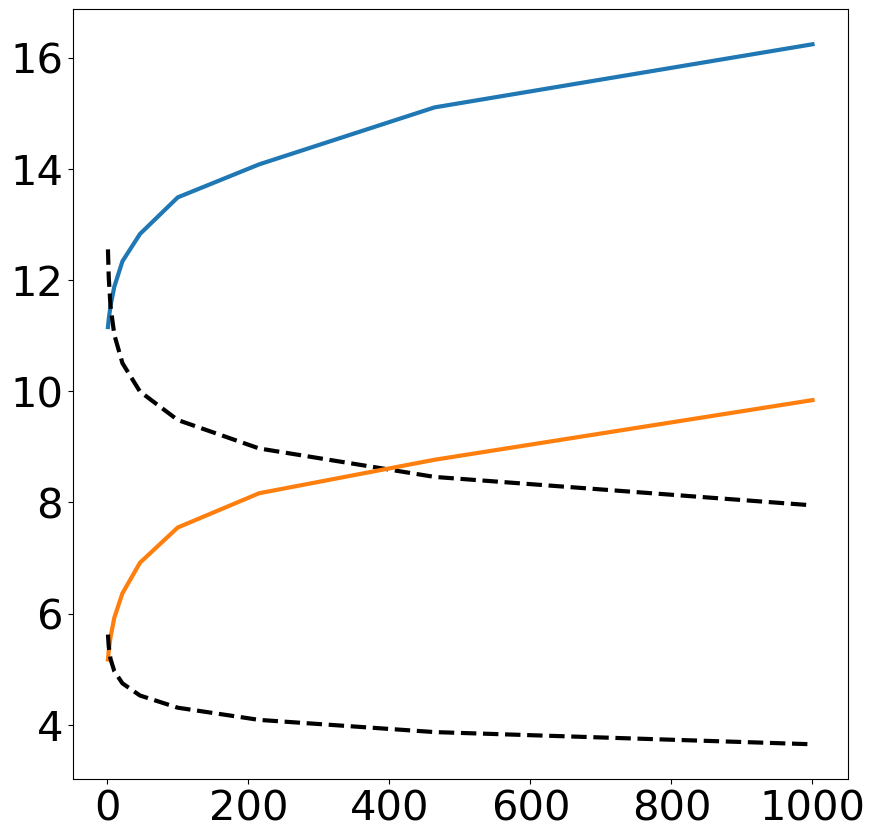

In [ ]:
fig,ax= plt.subplots(figsize=(10,10))
for R0 in R0s:
    ax.plot(kappa_s, t_peaks[R0], label = f'R0={R0}')
    theo_t_peak = 1/(R0-1)*np.log(N*(R0-1)/kappa_s)
    ax.plot(kappa_s, theo_t_peak, linestyle='--', color='black')


[45.35825001 40.59805136 35.62822314 30.32460209 24.40403673 16.93005655
         nan         nan         nan         nan]
[58.91669631 54.48559669 49.97445132 45.35825001 40.59805136 35.62822314
 30.32460209 24.40403673 16.93005655         nan]
[71.87710501 67.60193351 63.28477183 58.91669631 54.48559669 49.97445132
 45.35825001 40.59805136 35.62822314 30.32460209]


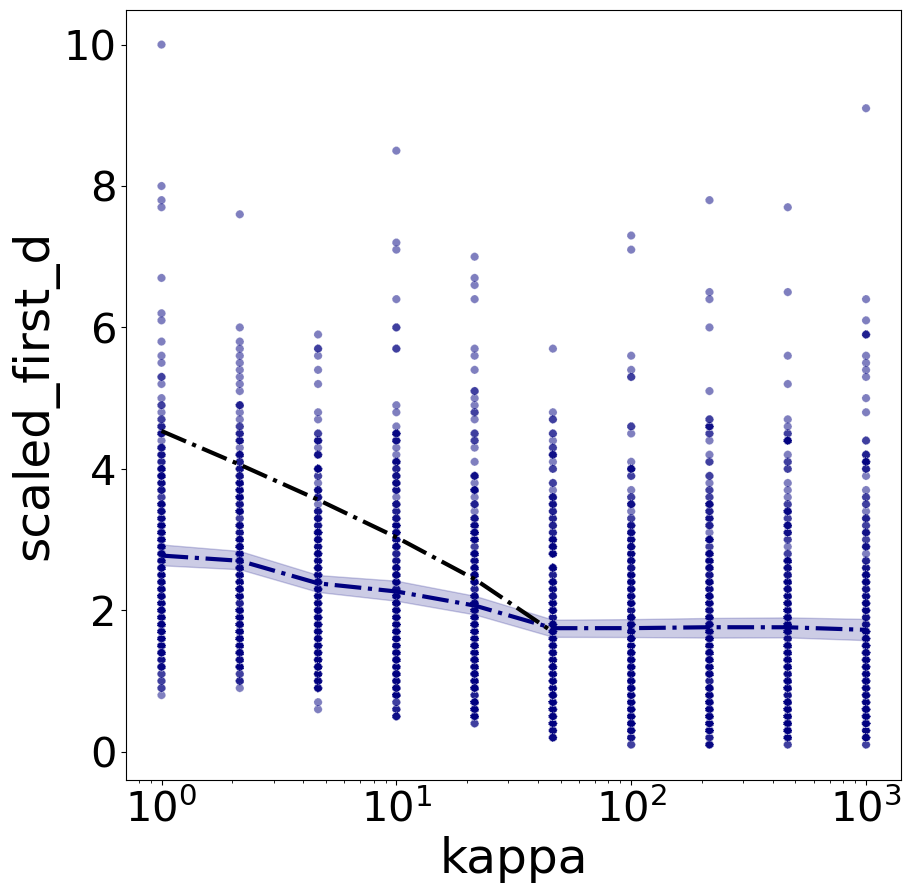

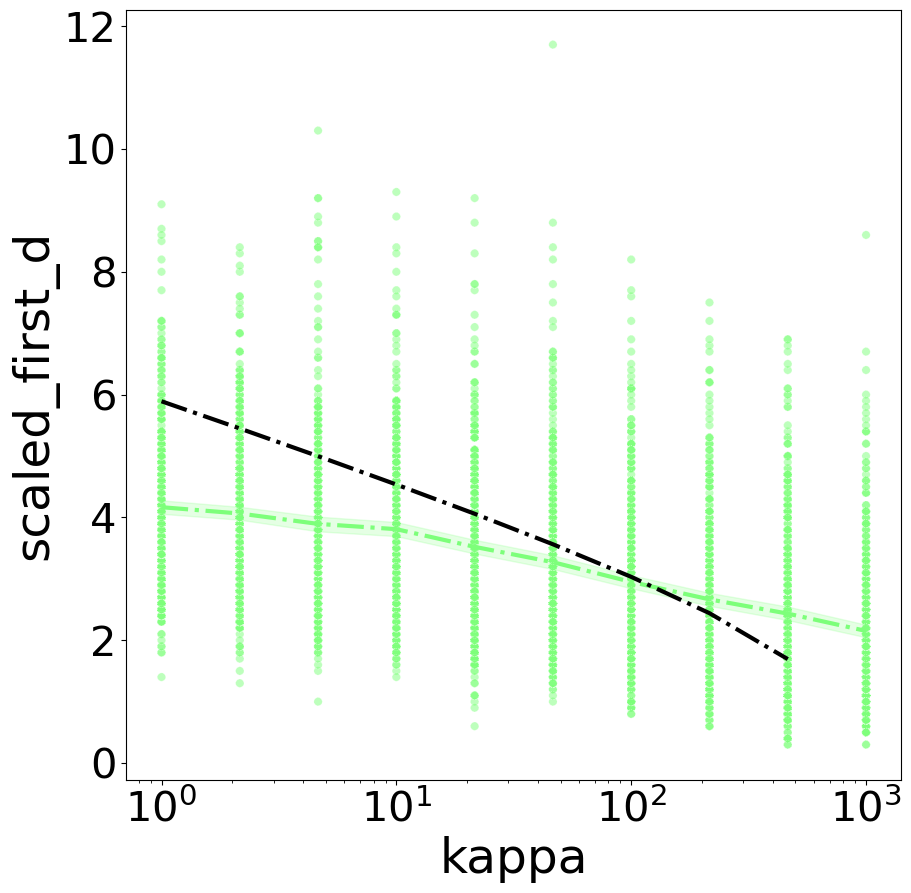

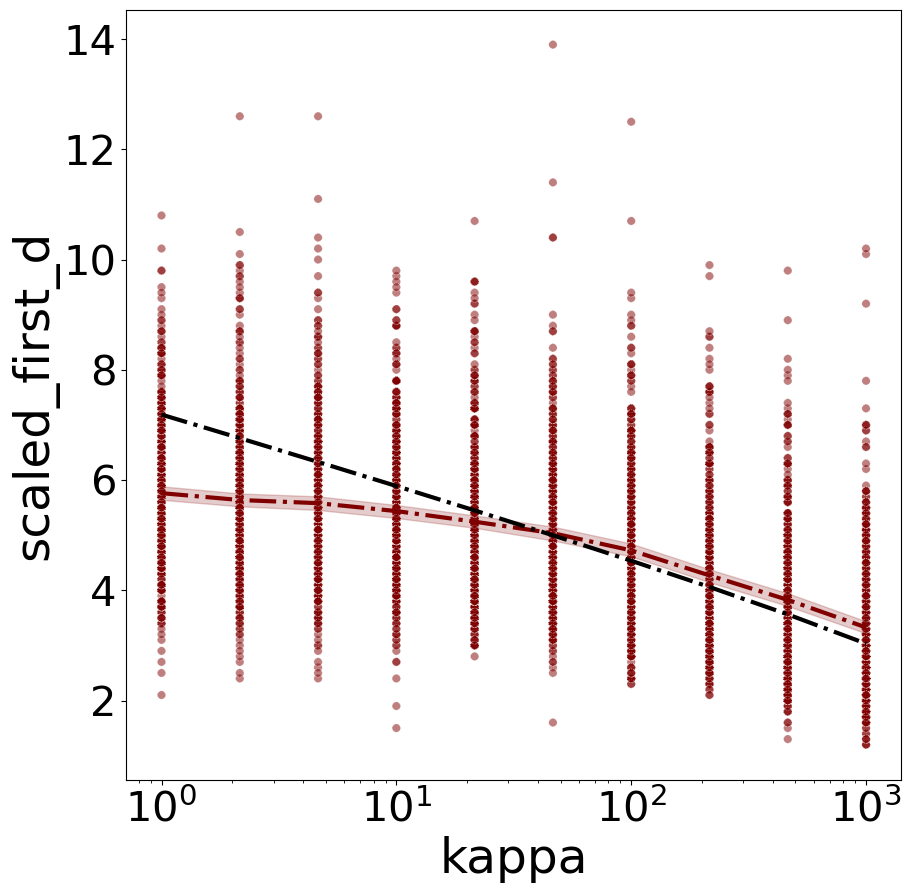

In [ ]:

for mu in mu_s:
    fig,ax = plt.subplots(figsize=(10,10))
    kc= mu*N/(2*R0)
    sns.scatterplot(data = filtered_df.query(f'infection_rate=={R0} and xi=={xi} and p_alpha=={p_alpha} and mutation_rate=={mu}'), x='kappa', y='scaled_first_d', ax=ax,color = color_mus[mu],linestyle='-.',alpha=.5)
    sns.lineplot(data = filtered_df.query(f'infection_rate=={R0} and xi=={xi} and p_alpha=={p_alpha} and mutation_rate=={mu}'), x='kappa', y='scaled_first_d', ax=ax,color = color_mus[mu],linestyle='-.')
    m = mu*N* (R0-1)/kappa_s
    d_m = dbar*(2+ 1/2*np.log(m*(1+np.log(m))))
    print(d_m)
    ax.plot(kappa_s,d_m/dbar, color='k', linestyle='-.')
    ax.set_xscale('log')

In [ ]:
filtered_df['first_d'].min()

1.0

In [ ]:
1+xi*np.log((dbar+xi)/xi)/dbar,dbar,np.log((dbar+xi)/xi)

(1.911607783969773, 10.0, 0.1823215567939546)

100%|██████████| 3/3 [00:00<00:00, 12.29it/s]


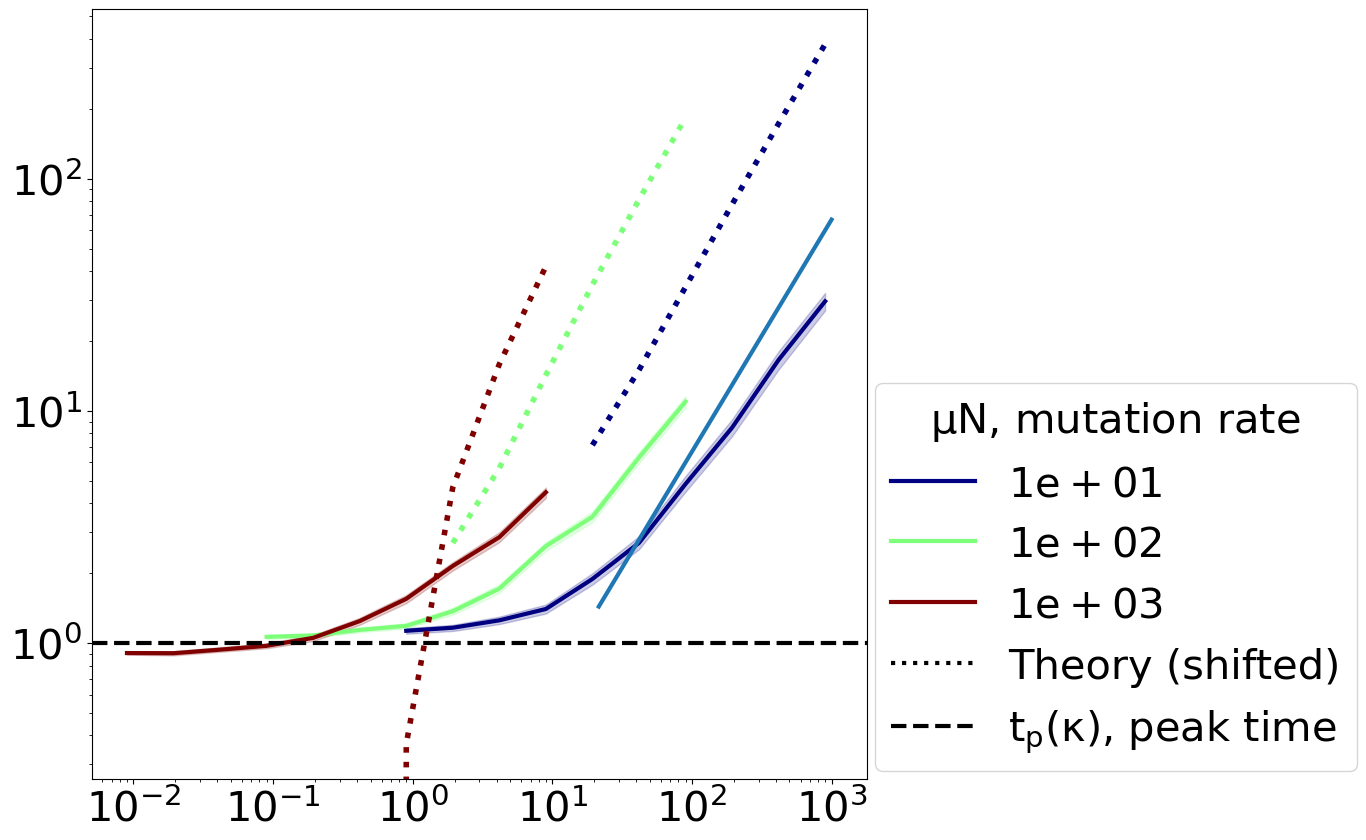

In [ ]:
fig,ax= plt.subplots( figsize=(10,10))            
for mu in tqdm(mu_s):
    kc = mu*N/(2*R0)# - (R0-1)/R0,1)
    # cl, = ax[0].plot(kappa_s[kappa_s>10]/kc, (d_mins_mu_kappa[mu])*p_alpha + shifted ,linestyle=':',color=colors_mu[mu],lw=4)
    # zb_mins = zb_mins_mu_kappa[mu]
    # z_infs_strong_control = z_inf_strong_control(R0,kappa_s)
    # z_infs_strong_control = z_infs_strong_control[kappa_s>10]
    # tb_mins = kappa_s[kappa_s>10]/R0*np.log(z_infs_strong_control/(z_infs_strong_control-zb_mins))
    # print(z_infs_strong_control)
    # ax.plot(kappa_s[kappa_s>10] / kc, tb_mins/t_peaks[R0][kappa_s>10],linestyle=':',color=colors_mu[mu],lw=4)
    # ax.plot(kappa_s[kappa_s>R0], d_mins2,linestyle='--',color=colors_mu[mu])
    short_kappa_s = kappa_s[kappa_s>10]

    mu_prime = mu/(1-tot_expected_established(z_inf_strong_control(R0,short_kappa_s),  mu, N, xi, p_alpha)/(np.exp(tot_expected_established(z_inf_strong_control(R0,short_kappa_s),  mu, N, xi, p_alpha))-1))
    


    z_infs = z_inf_strong_control(R0,short_kappa_s)
    z_peaks = R0/short_kappa_s*(np.log((R0-1)/(R0**2)*short_kappa_s)-(R0-1)/R0)
    t_estimate = -short_kappa_s/12*R0*np.log((z_infs - np.power(mu_prime*N/(2* p_alpha*xi),-1/2))/(z_infs-z_peaks))

    ax.plot(short_kappa_s / kc, t_estimate, linestyle=':',color=colors_mu[mu],lw=4)
    sns.lineplot(data =filtered_df.query(f'infection_rate=={R0} and mutation_rate=={mu} and xi=={xi} and p_alpha=={p_alpha}'), x='scaled_kappa', y='scaled_first_tb', ax=ax, color=colors_mu[mu], estimator = np.mean, label = f'${mu*N:.0e}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('')
ax.plot(short_kappa_s, short_kappa_s/15)
handles, labels = ax.get_legend_handles_labels()
handles += [Line2D([0], [0], color='k', linestyle=':', label='Theory' + shifted*' (shifted)'), Line2D([0], [0], color='k', linestyle='--', label=r'$t_\mathrm{p}(\kappa)$, peak time')]
ax.legend(handles=handles, title = '$\mu N$, mutation rate',loc=(1.01,.01), fontsize= 30, title_fontsize=30)

ax.axhline(1, color='black', linestyle='--')


In [ ]:
np.log(z_infs - np.power(mu*N/(2*p_alpha*xi/(1+ 1/p_alpha)),-1/2) / (z_infs - z_peaks))

array([-0.24609361, -0.281685  , -0.29522246, -0.30012871, -0.30183668,
       -0.30237917])

In [ ]:
lambda_d_t = lambda d,t, mu,N ,yp, zp, p_alpha ,xi:   mu* N* yp * zp/(1-zp)*(1-p_alpha)**d*(1- np.exp(-d/xi)/(1+1/(p_alpha*xi)))* ( t + np.log(N*yp)/((1-np.exp(-d/xi))*zp/(1-zp)))

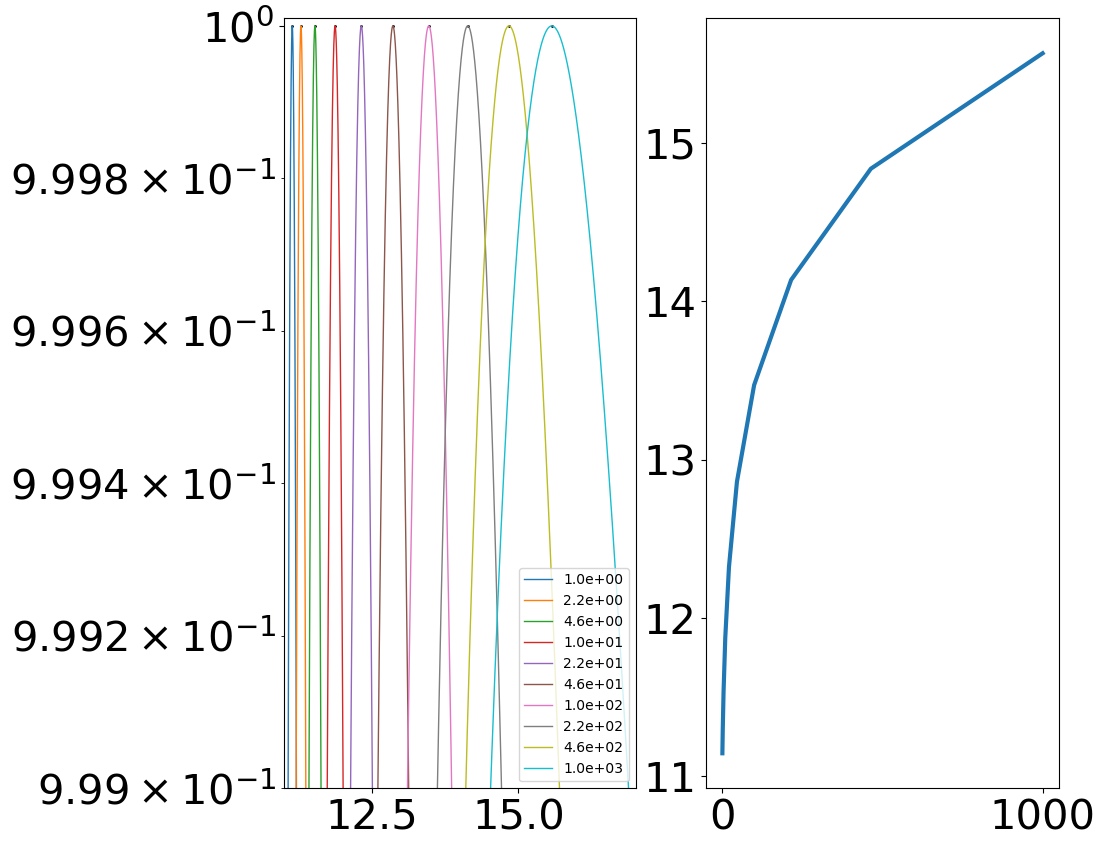

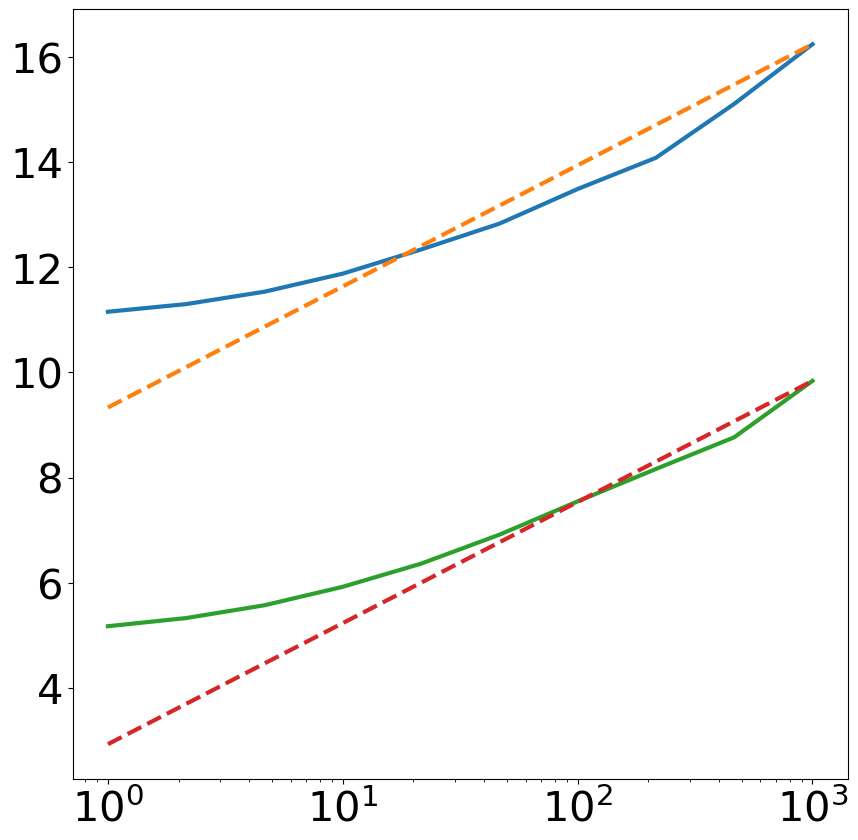

In [ ]:
R0=2.5
tpeaks_mini = []
ts_mini = np.linspace(0,35,1000000)
fig,ax= plt.subplots(1,2, figsize=(10,10))
for kappa in kappa_s:
    x,y,z = odeint(funcs.model, np.array([1-10/N,10/N,0]), ts_mini, args=(R0,kappa)).T
    ax[0].plot(ts_mini,y/max(y), label = f'{kappa:.1e}',lw=1)
    tpeaks_mini.append(ts_mini[np.argmax(y)])
    ax[0].scatter(ts_mini[np.argmax(y)],1, color='black',s=1)
    # ax[0].scatter(1/(R0-1)*np.log(N/10*(R0-1)/kappa),np.max(y), color='orange',zorder=10,marker='x')
    
ax[0].set_yscale('log')
ax[1].plot(kappa_s, tpeaks_mini)
peak_widths = np.sqrt(kappa_s/(R0-1))/2
# ax[1].plot(kappa_s, 1/(R0-1)*np.log(N*(R0-1)/kappa_s)+peak_widths, linestyle='--')

ax[0].set_ylim(0.999,1.00001)
ax[0].set_xlim(11,17)
# ax[0].set_xscale('log')
ax[0].legend(loc='lower right',fontsize=10)

fig,ax= plt.subplots( figsize=(10,10))
# ax.plot(kappa_s, 1/(R0-1)*np.log(N*(R0-1)/kappa_s)+peak_widths, linestyle='--')
for R0 in R0s:
    ax.plot(kappa_s, t_peaks[R0])
    
    ax.plot(kappa_s,t_peaks[R0][-1]+np.log(kappa_s/kappa_s[-1]), linestyle='--')
ax.set_xscale('log')

(0.0, 1.0)

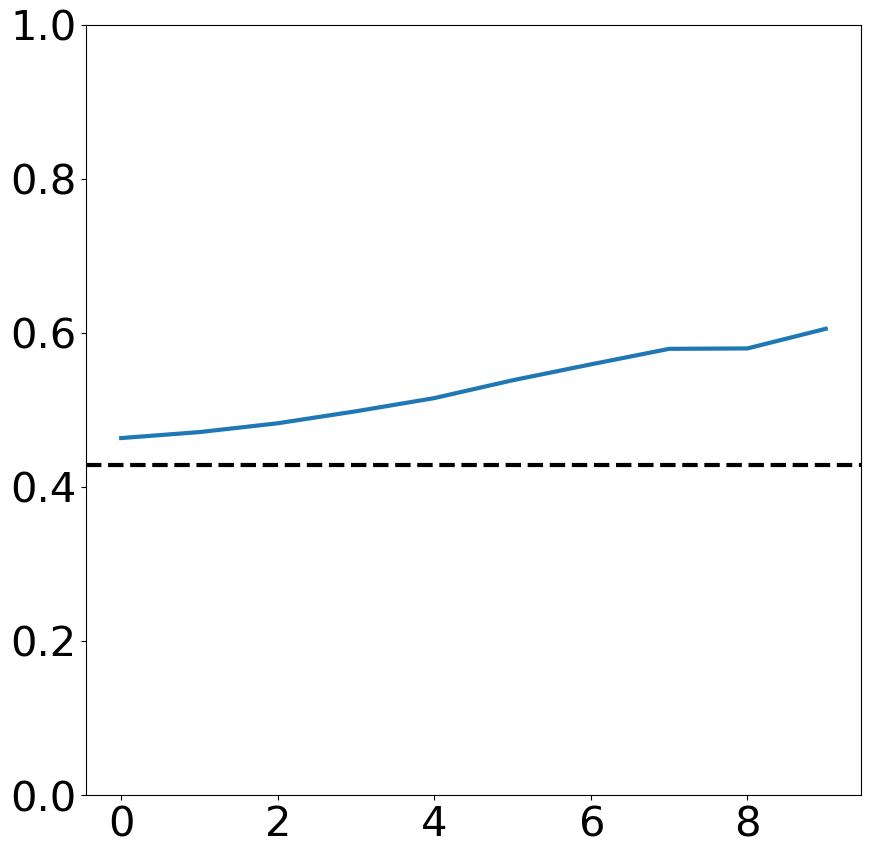

In [ ]:
fig,ax= plt.subplots( figsize=(10,10))
ax.plot(t_peaks[4.5]/t_peaks[2.5])
ax.axhline((2.5-1)/(4.5-1), color='black', linestyle='--')
ax.set_ylim(0,1)